In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau


class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.03),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 


class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (2*x*(h1))-2
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (2 * x * (h2))-(4 * h1)

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (2*x*(h3))-(6*h2)   
def softsign(x):
    return x / (1 + tf.abs(x))


# Configure the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.01,          # Reduce the learning rate by multiplying it by this factor
    patience=10,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001,      # The lower bound on the learning rate
    verbose=1            # Print a message when the callback takes action
)


2024-02-23 17:00:56.430491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 17:00:56.938929: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:


class ResNetHermiteBlock(layers.Layer):
    def __init__(self, filters, stride=1, **kwargs):
        super(ResNetHermiteBlock, self).__init__(**kwargs)
        self.stride = stride
        self.filters = filters
        
        # Initialize Hermite Polynomial layers
        self.h1 = H1Layer()
        self.h2 = H2Layer()
        self.h3 = H3Layer()
        self.h4 = H4Layer()
        
        # Initialize Convolutional and Batch Normalization layers
        self.conv1 = layers.Conv2D(filters, 3, strides=stride, padding="same", use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding="same", use_bias=False)
        self.bn2 = layers.BatchNormalization()

        # Pre-instantiate the Conv2D layer for shortcut adjustment
        self.shortcut_conv = layers.Conv2D(filters, 1, strides=stride, padding="same", use_bias=False)
        self.shortcut_bn = layers.BatchNormalization()

    def call(self, inputs):
        x = inputs
        x = self.conv1(x)
        x = self.bn1(x)
        x_h1 = self.h1(x)  # Store H1 output if needed for H2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.h2(x, x_h1)  # Pass x_h1 as the additional argument to H2Layer
        
        # Conditional application for shortcut
        if self.stride != 1 or inputs.shape[-1] != self.filters:
            shortcut = self.shortcut_conv(inputs)
            shortcut = self.shortcut_bn(shortcut)
        else:
            shortcut = inputs

        x += shortcut
        return x  # Note: You might apply another Hermite activation here if needed

def build_resnet18_hermite(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = H1Layer()(x)  # Starting with an H1 Hermite activation
    
    # Adding ResNetHermiteBlocks
    x = ResNetHermiteBlock(64, stride=1)(x)
    x = ResNetHermiteBlock(64, stride=1)(x)
    x = ResNetHermiteBlock(128, stride=2)(x)
    x = ResNetHermiteBlock(128, stride=1)(x)
    x = ResNetHermiteBlock(256, stride=2)(x)
    x = ResNetHermiteBlock(256, stride=1)(x)
    x = ResNetHermiteBlock(512, stride=2)(x)
    x = ResNetHermiteBlock(512, stride=1)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
model = build_resnet18_hermite((32, 32, 3), 10)
model.summary()

2024-02-23 17:00:57.638689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 17:00:57.657906: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-23 17:00:57.658094: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1728      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 h1_layer (H1Layer)          (None, 32, 32, 64)        64        
                                                                 
 res_net_hermite_block (Res  (None, 32, 32, 64)        74304     
 NetHermiteBlock)                                                
                                                                 
 res_net_hermite_block_1 (R  (None, 32, 32, 64)        74304 

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)


In [4]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=200,
                    validation_data=(x_test, y_test),
                    callbacks=[reduce_lr])


Epoch 1/200


2024-02-23 17:01:03.462962: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-02-23 17:01:04.309480: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-23 17:01:04.311677: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1c93ff20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-23 17:01:04.311707: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-02-23 17:01:04.318038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-23 17:01:04.421250: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 [==============================] - 27s 23ms/step - loss: 1.5548 - accuracy: 0.4574 - val_loss: 1907607420983702049590517694464.0000 - val_accuracy: 0.1177 - lr: 0.0010
Epoch 2/200
782/782 [==============================] - 16s 21ms/step - loss: 1.0565 - accuracy: 0.6306 - val_loss: 2.1177 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/200
782/782 [==============================] - 16s 21ms/step - loss: 0.8479 - accuracy: 0.7106 - val_loss: 230.1729 - val_accuracy: 0.4595 - lr: 0.0010
Epoch 4/200
782/782 [==============================] - 16s 21ms/step - loss: 0.7148 - accuracy: 0.7586 - val_loss: 5724.2334 - val_accuracy: 0.5014 - lr: 0.0010
Epoch 5/200
782/782 [==============================] - 16s 21ms/step - loss: 0.6144 - accuracy: 0.7904 - val_loss: 1194.7516 - val_accuracy: 0.5705 - lr: 0.0010
Epoch 6/200
782/782 [==============================] - 16s 21ms/step - loss: 0.4840 - accuracy: 0.8356 - val_loss: 9.4965 - val_accuracy: 0.2593 - lr: 0.0010
Epoch 7/200
782/782 [=====

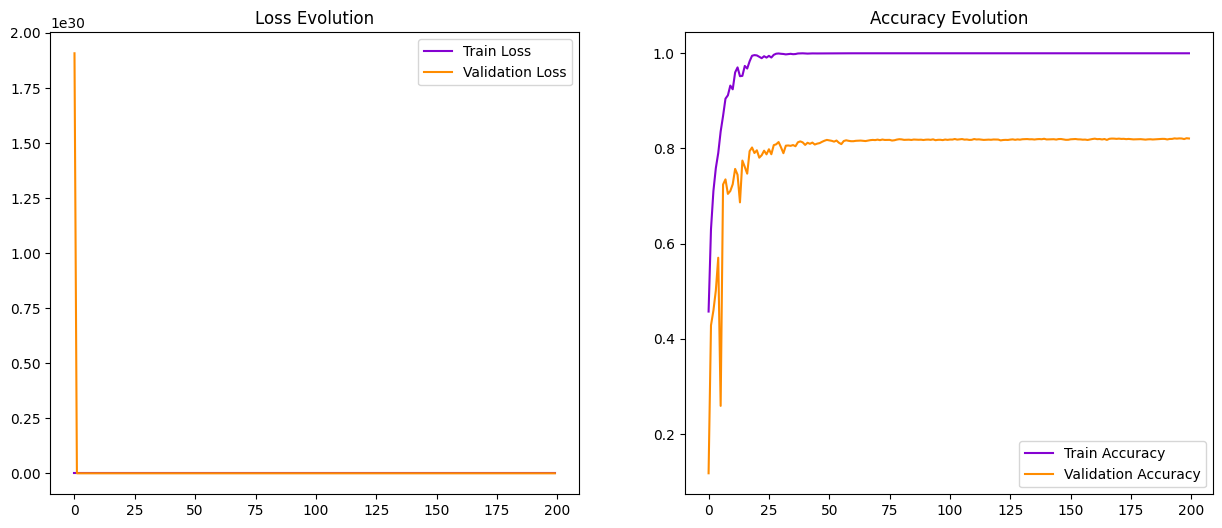

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='#8502d1')
plt.plot(history.history['val_loss'], label='Validation Loss', color='darkorange')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#8502d1')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()